In [15]:
from typing import List
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

def gms_cost(current_star, level):
    if current_star < 10:
        cost = 100 * ((level**3) * (current_star+1)/2_500 + 10)
    elif current_star < 15:
        cost = 100 * ((level**3) * ((current_star+1)**2.7)/40_000 + 10)
    else:
        cost = 100 * ((level**3) * ((current_star+1)**2.7)/20_000 + 10)
    return cost
    
def get_base_cost(current_star, level):
    cost = gms_cost(current_star, level)
    #game rounds to nearest 100
    #print(f"True cost for {current_star} of level {level} equip: {cost}")
    return round(cost/100)*100

def attempt_cost(current_star, item_level, sg, chance_time, multiplier=1):
    if sg and not chance_time and 12>=current_star>=16:
        multiplier+=1
    cost = get_base_cost(current_star, item_level) * multiplier
    return round(cost)

def determine_outcome(current_star, rates, star_catch, sg):
    p_success, p_maintain, p_decrease, p_boom = rates[current_star]

    #Take into account events 5 10 15 affects makes the success chance 100% for those stars.
    if "5_10_15" in event:
        if int(current_star) in (5, 10, 15):
            p_success = 1.0
    
    if sg and current_star <= 16:
      p_boom = 0
      p_decrease += p_boom

    if star_catch: #star catch adjustment
        p_success *= 1.045
    left_over = 1 - p_success
    if p_decrease == 0:
        p_maintain = p_maintain * (left_over) / (p_maintain + p_boom)
        p_boom = left_over - p_maintain
    else: 
        p_decrease = p_decrease * (left_over) / (p_decrease + p_boom)
        p_boom = left_over - p_decrease
    
    #No boom room 
    if "no_boom" in event and current_star <= 15:
        p_boom = 0

    outcome = random.random()

    if outcome <= p_success:
        #successful star increase
        return "success"
    elif p_success < outcome <= p_success + p_maintain:
        #in the probability range to stay the same
        return "maintain"
    elif p_success + p_maintain < outcome <= p_success + p_maintain + p_decrease:
        #star decreases
        return "drop"
    elif p_success + p_maintain + p_decrease < outcome <= p_success + p_maintain + p_decrease + p_boom:
        #item booms
        return 'boom'
    else:
        #catching corner case
        return 'success'

def perform_simulation(current_star, desired_star, rates, level, sg, star_catch, fodder=False, fodder_current_star=-1, fodder_desired_star=-1):


    def star_direct(current_star, desired_star, rates, level, sg, star_catch, foddered=False):
        total_meso = 0
        total_boom = 0
        decrease_counter = 0
        
        while current_star < desired_star:
            # if foddered:
            #     print(f"Attempting level {level} fodder from {current_star} to {current_star+1}")
            # else:
            #     print(f"Attempting level {level} gear from {current_star} to {current_star+1}")
            chance_time = decrease_counter==2
            #if event is 30% off or shining, the base cost is 70% of normal
            if "30_off" in event:
                cost = attempt_cost(current_star, level, sg, chance_time, multiplier=0.7)
                
                cost_normal = attempt_cost(current_star, level, sg, chance_time)
                #print(cost, cost_normal)
            else:
                cost = attempt_cost(current_star, level, sg, chance_time)

            total_meso += cost
            if chance_time: #guaranteed success
                outcome = 'success'
                decrease_counter = 0 
                current_star += 1
            else:
                outcome = determine_outcome(current_star, rates, star_catch, sg)
                #One 1+1, if the star is 10 or less you get another star for free too!
                if "1+1" in event and current_star <= 10 and outcome=='success':
                    decrease_counter = 0
                    current_star += 2
                elif outcome=='success':
                    decrease_counter = 0
                    current_star += 1
                elif outcome=='maintain':
                    decrease_counter = 0
                elif outcome=='drop':
                    decrease_counter += 1
                    current_star -= 1
                elif outcome =='boom':
                    decrease_counter = 0
                    current_star = 12
                    total_boom += 1
                    if foddered:
                        #if the equip was foddered and it booms, go back to the fodder equip and increase booms of the final piece 
                        #print("Final piece boomed!")
                        return total_meso, total_boom
                    else:
                        #print("Fodder item boomed!")
                        pass
            #print(current_star)
        #print(f"The level {level} equip made it to {desired_star} stars!")
        
        return total_meso, total_boom


    if not fodder:
        total_meso, total_boom = star_direct(current_star, desired_star, rates, level, sg, star_catch)
        return total_meso, total_boom, 0
    else:
        final_booms = 0
        total_meso = 0
        total_boom = 0
        fodder_booms = 0

        final_current_star = current_star
        while final_current_star < desired_star:
            #star transfer gear
            #print(f"Starring level {level-10} gear to {fodder_desired_star}")
            fodder_tap_meso, fodder_tap_booms  = star_direct(fodder_current_star, fodder_desired_star, rates, level-10, sg, star_catch)
            total_meso += fodder_tap_meso
            fodder_booms += fodder_tap_booms
            #the fodder gear has reached the correct star
            #transfer hammer reduces star by 1
            final_current_star = fodder_desired_star - 1
            #now tap the final piece up. If it booms, increase the booms of the final piece
            final_tap_meso, final_tap_booms = star_direct(final_current_star, desired_star, rates, level, sg, star_catch, True)
            final_booms += final_tap_booms
            #If this final tap succeeded we need to break out of the loop
            if final_tap_booms==0:
                final_current_star = desired_star
        #print("-"*50)
        return total_meso, final_booms, fodder_booms

    
def repeat_experiment(n_trials, current_star, desired_star, rates, item_level, sg, star_catch, fodder, fodder_current_star, fodder_desired_star):
    meso_result_list = []
    boom_result_list = []
    fodder_result_list = []

    for i in range(n_trials):
        trial_meso, trial_final_boom, trial_fodder_boom = perform_simulation(current_star, desired_star, rates, item_level, sg, star_catch, fodder, fodder_current_star, fodder_desired_star)
        meso_result_list.append(trial_meso)
        boom_result_list.append(trial_final_boom)
        fodder_result_list.append(trial_fodder_boom)
    
    
    return meso_result_list, boom_result_list, fodder_result_list


def display_results(mesos_array: List[float], main_booms_array: List[float], fodder_booms_array: List[float]):
    from matplotlib.ticker import FuncFormatter

    #convert mesos, booms to arrayLike
    mesos_array = np.array(mesos_array)
    main_booms_array = np.array(main_booms_array)
    fodder_booms_array = np.array(fodder_booms_array)

    #making a number format function
    def x_fmt(y, pos):
        decades = [1e9, 1e6, 1e3, 1e0]
        suffix  = ["b", "m", "k", ""]
        if y == 0:
            return str(0)
        for i, d in enumerate(decades):
            if np.abs(y) >=d:
                val = y/float(d)
                signf = len(str(val).split(".")[1])
                if signf == 0:
                    return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
                else:
                    if signf == 1:
                        if str(val).split(".")[1] == "0":
                            return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                    tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                    return tx.format(val=val, suffix=suffix[i])

                    #return y
        return y

    ###Data visualizations

    fig = plt.figure()
    
    
    #mesos distribution

    q3, q1 = np.percentile(mesos_array, [75, 25])

    ax1 = fig.add_subplot(2,2,(3,4))
    n_mesos, bins_mesos, patches = ax1.hist(mesos_array, bins = 100)
    ax1.set_xlabel("Cost (mesos)")
    ax1.set_ylabel("Frequency (counts)")
    ax1.set_title("Distribution of mesos spent.")
    ax1.xaxis.set_major_formatter(FuncFormatter(x_fmt))
    
    ax1.vlines(q1, 0, max(n_mesos), colors='grey', linestyles='-', label='25th %ile')
    ax1.vlines(np.median(mesos_array), 0, max(n_mesos), colors='red', linestyles='-', label='Median')
    ax1.vlines(np.average(mesos_array), 0, max(n_mesos), colors='purple', linestyles='-', label='Average')
    ax1.vlines(q3, 0, max(n_mesos), colors='grey', linestyles='-', label='75th %ile')
    ax1.legend()

    #main booms distribution
    ax2 = fig.add_subplot(2,2,2)
    ax2.hist(main_booms_array, bins = 20)
    ax2.set_xlabel("Num Booms")
    ax2.set_ylabel("Frequency (counts)")
    ax2.set_title("Distribution of target item booms")
    ax2.xaxis.set_major_formatter(FuncFormatter(x_fmt))

    ax3 = fig.add_subplot(2,2,1)
    ax3.hist(fodder_booms_array, bins = 20)
    ax3.set_xlabel("Num Booms")
    ax3.set_ylabel("Frequency (counts)")
    ax3.set_title("Distribution of target item booms")
    ax3.xaxis.set_major_formatter(FuncFormatter(x_fmt))


    #Numbers
    print(f"Average mesos spent: {np.average(mesos_array):,} \t Median mesos spent: {np.median(mesos_array):,}")
    print(f"IQR mesos spent: {q1:,} to {q3:,}")
    print(f"Average final items boomed: {np.average(main_booms_array):.2f} \t Median final items boomed: {np.median(main_booms_array):.2f}")
    print(f"Average fodder items boomed: {np.average(fodder_booms_array):.2f} \t Median fodder items boomed: {np.median(fodder_booms_array):.2f}")


    
    plt.tight_layout()
    plt.show()

Average mesos spent: 9,705,466,488.732 	 Median mesos spent: 6,881,041,860.0
IQR mesos spent: 3,144,072,085.0 to 13,313,709,955.0
Average final items boomed: 0.93 	 Median final items boomed: 0.00
Average fodder items boomed: 9.94 	 Median fodder items boomed: 7.00


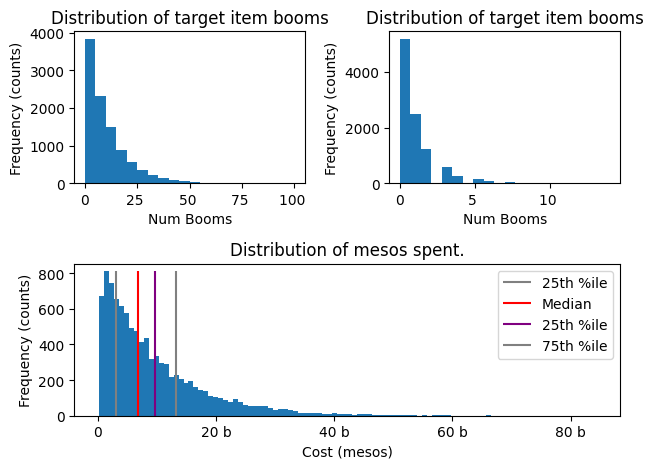

In [16]:

if __name__=='__main__':
    rates = [
        [0.95, 0.05, 0, 0], #0 stars
        [0.9, 0.1, 0, 0], #1 stars
        [0.85, 0.15, 0, 0], #2 stars
        [0.85, 0.15, 0, 0], #3 stars
        [0.80, 0.2, 0, 0], #4 stars
        [0.75, 0.25, 0, 0], #5 stars
        [0.7, 0.3, 0, 0], #6 stars
        [0.65, 0.35, 0, 0], #7 stars
        [0.6, 0.4, 0, 0], #8 stars
        [0.55, 0.45, 0, 0], #9 stars
        [0.5, 0.5, 0, 0], #10 stars
        [0.45, 0, 0.55, 0], #11 stars
        [0.4, 0.0, 0.594, 0.006], #12 stars
        [0.35, 0.0, 0.637, 0.013], #13 stars
        [0.3, 0.0, 0.686, 0.014], #14 stars
        [0.3, 0.679, 0, 0.021], #15 stars
        [0.3, 0.0, 0.679, 0.021], #16 stars
        [0.3, 0.0, 0.679, 0.021], #17 stars
        [0.3, 0.0, 0.672, 0.028], #18 stars
        [0.3, 0.0, 0.672, 0.028], #19 stars
        [0.3, 0.63, 0, 0.07], #20 stars
        [0.3, 0, 0.63, 0.07], #21 stars
        [0.03, 0.0, 0.776, 0.194], #22 stars
        [0.02, 0.0, 0.686, 0.294], #23 stars
        [0.01, 0.0, 0.594, 0.396] #24 stars
    ]

    #event can be any of {"5_10_15", "no_boom", '1+1', "30_off", None}
    event = {"30_off"}
    n_trials = 10000
    current_star = 0
    desired_star = 22
    item_level = 150
    sg = False
    star_catch = True
    foddering = {
        "fodder": True,
        "fodder_current_star": 0,
        "fodder_desired_star": 21
    }

    results = repeat_experiment(n_trials, current_star, desired_star, rates, item_level, sg, star_catch, **foddering)
    display_results(*results)

# New Section